# Float example

This notebook shows a simple example for backtracking particles near the 

In [36]:
# Define your own Kernel - could use this to add diel migration, other behavior
def MyKernel(particle, fieldset, time):
    
    # set particle salinity at new depth for output
    particle.salt =  fieldset.salt[time, particle.depth, particle.lat, particle.lon]

    # can code vertical diffusivity here with random walk
    # ocean parcels has some random walk functions as well
    # have particle.dt for time step, particle.depth for depth
    
    # for now, lock to depth (surface)
    particle.depth = 0
    

In [37]:
def OutOfBounds ( particle , fieldset , time ):
    # if particles go out of bounds stop tracking (will put NaNs into output file as location of untracked particle)
    particle.delete ()

Run OceanParcels with the Custom Kernel.  Thus horizontal advection (and updated position) will be handled by OceanParcels and interpolation of hydrography by the MyKernel

In [38]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
from datetime import timedelta, datetime
import numpy as np
import pandas as pd

# Load the HYCOM Analysis data in the Gulf of Maine
# The paths/datafiles should be read in from a control file
filenames = {'U': "../Preprocessing/OXYsurf_2021-12-01_2022-01-31.nc",
             'V': "../Preprocessing/OXYsurf_2021-12-01_2022-01-31.nc",
             'salt': "../Preprocessing/OXYsurf_2021-12-01_2022-01-31.nc"}
variables = {'U': 'water_u',
             'V': 'water_v',
             'salt': 'salinity'}
dimensions = {'lat': 'lat', 'lon': 'lon', 'depth' : 'depth' , 'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,allow_time_extrapolation = False)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

# print the domain boundaries to the screen
print("domain boundaries")
print(fieldset.U.lon[0],fieldset.U.lon[-1],fieldset.U.lat[0],fieldset.U.lat[-1])

    
# Define a new Particle type including extra Variables
class MyParticle(JITParticle):
    salt = Variable('salt', dtype=np.float32, initial=np.nan)  # store salinity

# Initiate two particles with staggered starts and two strating points.  
# These variables here (lon, lat, time) should be read in from an initial particle position file
# pset = ParticleSet.from_list(fieldset=fieldset,
#                             pclass=MyParticle,
#                             lon=[245,250],
#                             lat=[5,10],
#                             depth=[0,0],
#                             time=[datetime(2022,1, 31,0,0,0),
#                             datetime(2022,1,31,0,0,0)])

# n_part = 20
t1 = datetime(2022,1,10,0,0,0)
t2 = datetime(2022,1,12,0,0,0)

n_part = int ((t2-t1).days)
print(n_part)
print(tvec)
tvec = [ t1 + timedelta(n) for n in range(int ((t2-t1).days))]


n_part = 50
pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=MyParticle, 
                             size=n_part, 
                             start=(270,10), 
                             finish=(260,15),
                             depth=0,
                             time=[datetime(2022,1, 1,0,0,0)])
                             

# combine user-defined custom kernel with built-in Advection kernel
kernels = MyKernel + pset.Kernel(AdvectionRK4)
#kernels = IsoPycnalVerticalMovement + pset.Kernel(AdvectionRK4)

# Create a ParticleFile object to store the output
# outputdt might be read in from a control file
output_file = pset.ParticleFile(name="oxy1_tracks.zarr", outputdt=timedelta(minutes=30))

# Now execute the kernels 
# for backtracking use a negative value for dt
pset.execute(kernels, runtime=timedelta(days=4), dt=timedelta(minutes=-5), output_file=output_file)

# complete, report to screen
print("done tracking")


domain boundaries
240.08002 280.0 0.04 40.0
2
[datetime.datetime(2022, 1, 10, 0, 0), datetime.datetime(2022, 1, 11, 0, 0)]


INFO: Compiled ArrayMyParticleMyKernelAdvectionRK4 ==> /var/folders/bn/dmp7fjns0klgnb_h42x7h6nr0000gn/T/parcels-501/libc13bdaa7699912f3983dc78be84f7747_0.so


done tracking


Now we can plot the trajectory of the Isopycnal float with some simple calls to netCDF4 and matplotlib

/Users/gcowles/miniconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


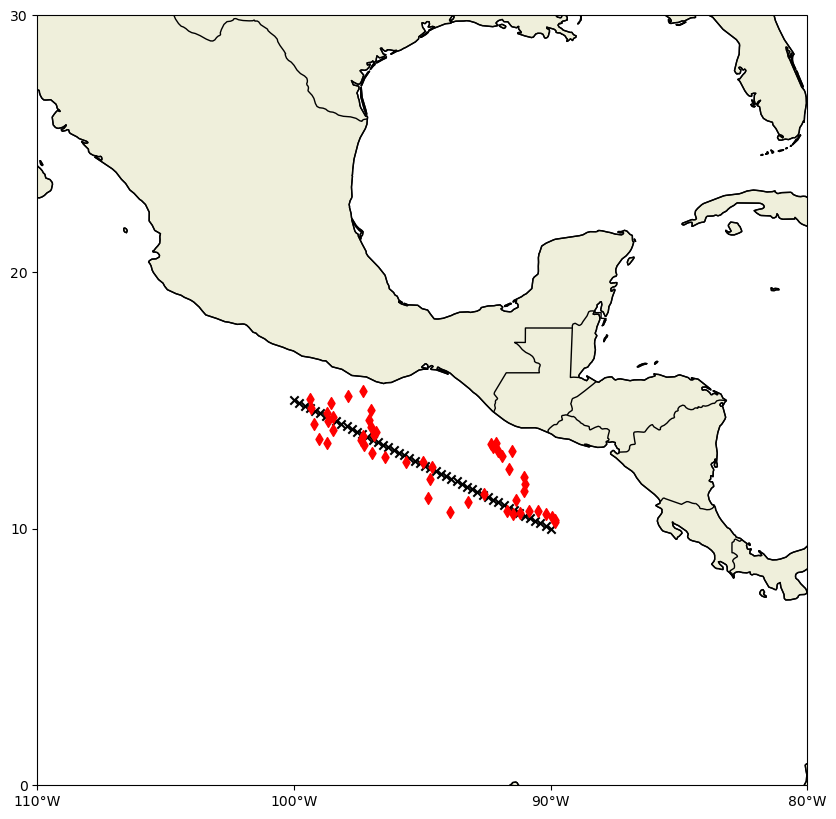

In [39]:
%matplotlib inline
#uncomment below for interactive plots (need ipympl)
####%matplotlib widget
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# set figure size to use full window
plt.rcParams['figure.figsize'] = [10,10]

# plot gebco bathy contours 
ds = netCDF4.Dataset('gebco_2021_n50.0_s30.0_w-80.0_e-50.0.nc')
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
elev = ds.variables['elevation'][:]

# read data
data_xarray = xr.open_zarr('oxy1_tracks.zarr')
xp = data_xarray['lon'].values
yp = data_xarray['lat'].values


ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-110,-80,0, 30], ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xticks([-110,-100,-90,-80], crs=ccrs.PlateCarree())
ax.set_yticks([0,10,20,30], crs=ccrs.PlateCarree())

ax.plot(xp[1,:],yp[1,:],c='k')

for p in range(xp.shape[0]):
    cb = ax.plot(xp[p,:], yp[p,:])#, c='m')#, s=20)#, marker="o")
    

ax.scatter(xp[:,0],yp[:,0],c='k',marker="x") 
ax.scatter(xp[:,-1],yp[:,-1],c='r',marker="d") 
